# Steinschlag Challenge

## Mitglieder
- Julia Lobatón
- Lukasz Gothszalk
- Patrick Schürmann
- Thomas Mandelz

## Einführung

Nachfolgend unsere Abgabe zur Steinschlag Challenge DS HS 2021.




## Vorbereitung und Funktionsdefinition

In [1]:
# Import Bibliotheken
from scipy import stats
from statistics import mean
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from numpy.random import default_rng

# Globale Variablen
# Anzahl Durchgänge in der Monte Carlo Simulation
sizeMonteCarloSim = 8_000_000
# Grenzwert der Wahrscheinlichkeit
LimitProbability = 10 ** -4



#Pandas Warnungen ausblenden für Ketten Aufrufe
pd.options.mode.chained_assignment = None  # default='warn'


In [2]:

# Funktion welche ein Verteilungart fitten kann
def FindmostfittingDistribution(ColumnName,MatrixColumn):

    #Unterdrückt Division durch 0 Warnungen
    with np.errstate(divide='ignore',invalid='ignore'):
        # Liste von Verteilungen welche gefittet werden können
        list_of_dists = ['cauchy','expon', 'logistic', 'norm','uniform','gamma']
    
        results = []
        # Kolmogorov-Smirnov Test für jede Verteilung um den Typ zu finden
        for i in list_of_dists:
            dist = getattr(stats, i)
            param = dist.fit(MatrixColumn)
            a = stats.kstest(MatrixColumn, i, args=param)
            results.append((i, a[0], a[1]))

        # sortieren der Resultate nach Höchstem PWert
        results.sort(key=lambda x: float(x[2]), reverse=True)
        #Plotten von Verteilung
        MatrixColumn.hist()
        
        # Ausgabe der Resultate
        print(f"Die folgenden Verteilungen der Spalte {ColumnName} wurden geprüft und fitten am besten in absteigender Reihenfolge:")
        for j in results:
            print("{}: pvalue={}".format(j[0], j[1], j[2]))
        
        

# Funktion um die CSV's zu lesen
def ReadDataframe():
    # Lesen der ersten CSV Datei
    dataFile1 = pd.read_csv("out_1.csv")
    # Lesen der zweiten CSV Datei
    dataFile2 = pd.read_csv("out_2.csv")

    # Zonen werden als Spalte ergänzt
    dataFile1['zone']='1'
    dataFile2['zone']='2'

    # Zusammenführen der beiden Zonen Datenframes
    mergedDataFile = dataFile1.append(dataFile2)
    return mergedDataFile

# Funktion zur Berechnung eines Zeitunterschieds und Ergänzung der jeder Stunde im Datenframe als Row
def CalculateTimeDeltaHours(zone):
    # Auswahl der Zone
    mergedDataFileZone = mergedDataFile.loc[mergedDataFile['zone'] == zone]
    # Zeitunterschiede von einem Stein zum nächsten Berechnen 
    TimebeforeStone = mergedDataFileZone["DateTime"].diff()
    # Stunde dazwischen als Rows ergänzen
    mergedDataFileZone["TimebeforeStone"] = TimebeforeStone.astype('timedelta64[h]').fillna(0)
    return mergedDataFileZone


# Bereinigungen und Berechnungen der Datenframes
def CalculateandUpdateColumns(mergedDataFile):
    
    #Energie mittels der Formel (KE=1/2mv^2)/1000 in m = kg und v = m/s -> Joule
    mergedDataFile['energy']=((mergedDataFile['mass']/2)*(mergedDataFile['velocity']**2) / 1000)

    # Auslöser Spalte ergänzen wenn ein Stein gefallen ist
    mergedDataFile["Trigger"] = np.where(mergedDataFile["zone"] == 0, 0, 1) 

    # Umformatierung zum Datums Datentyp
    mergedDataFile["DateTime"] = pd.to_datetime(mergedDataFile['date'] + ' ' + mergedDataFile['timestamp'])

    # Nach Datum ordnen
    mergedDataFile = mergedDataFile.sort_values(by=['DateTime'])
    mergedDataFile = mergedDataFile.reset_index(drop=True)
    # Verschieben der Steine um eine Stunde welche zur gleichen Stunde fallen
    mergedDataFile.loc[1, 'timestamp'] = "10:00"
    mergedDataFile.loc[44, 'timestamp'] = "13:00"
    mergedDataFile.loc[89, 'timestamp'] = "13:00"

    # Update der Datumsspalte
    mergedDataFile["DateTime"] = pd.to_datetime(mergedDataFile['date'] + ' ' + mergedDataFile['timestamp'])

    # Zeitunterschiede von einem Stein zum nächsten Berechnen und Stunden dazwischen als Rows ergänzen
    mergedDataFileTemp = pd.DataFrame()
    for zone in range(1,3):
        mergedDataFileZone = CalculateTimeDeltaHours(str(zone))
        mergedDataFileTemp = mergedDataFileTemp.append(mergedDataFileZone)
    return mergedDataFileTemp

# Funktion zur Erstellung der Timeserie für die Plots
def TimeSeriePlots(mergedDataFile):
        # Leere Stunden ergänzen
        dfTimeSerie = mergedDataFile
        dfTimeSerie = dfTimeSerie.set_index(mergedDataFile["DateTime"])
        dfTimeSerie = dfTimeSerie.resample('H').first().fillna(0)
        dfTimeSerie['DateTime'] = dfTimeSerie.index

        # Fehlende Tage und Stunden ergänzen
        dfTimeSerie["date"] = dfTimeSerie["DateTime"].dt.date
        dfTimeSerie["timestamp"] = dfTimeSerie["DateTime"].dt.time
        
        # berechnen der rollierenden Energie sowie masse über 24 Stunden
        dfTimeSerie["rollingEnergy24h"] = dfTimeSerie["energy"].rolling(24, min_periods=1).sum()
        dfTimeSerie["rollingmass24h"] = dfTimeSerie["mass"].rolling(24, min_periods=1).sum()


        # Berechnung ob Durchbrüche beobachtet wurden mittels Durchbruchkriterien
        dfTimeSerie["BreachEnergy"] = np.where(dfTimeSerie["energy"] >= 1000, 1, 0)
        dfTimeSerie["BreachFullNet"] = np.where((dfTimeSerie["energy"] >= 500) & (dfTimeSerie["rollingmass24h"] >= 2000), 1, 0)
        return dfTimeSerie   

## Aufbereitung der Daten

In [3]:
listfeatures_samples = pd.DataFrame()
mergedDataFile = ReadDataframe()
mergedDataFile = CalculateandUpdateColumns(mergedDataFile)
dfTimeSerie = TimeSeriePlots(mergedDataFile)
dataFile1 = mergedDataFile.loc[mergedDataFile['zone'] == "1"]
dataFile2 = mergedDataFile.loc[mergedDataFile['zone'] == "2"]

## Verteilungfitting 

Die folgenden Verteilungen der Spalte Masse Zone 1 wurden geprüft und fitten am besten in absteigender Reihenfolge:
expon: pvalue=0.11243165125691623
gamma: pvalue=0.11760617507322291
cauchy: pvalue=0.1801401376182128
logistic: pvalue=0.18169255347020843
norm: pvalue=0.2414309639409059
uniform: pvalue=0.5275093219694087
Die folgenden Verteilungen der Spalte Masse Zone 2 wurden geprüft und fitten am besten in absteigender Reihenfolge:
expon: pvalue=0.14782678488159295
cauchy: pvalue=0.18430641176211526
logistic: pvalue=0.2007862539643812
gamma: pvalue=0.2186223695992287
norm: pvalue=0.2734792372426059
uniform: pvalue=0.4978448275862069


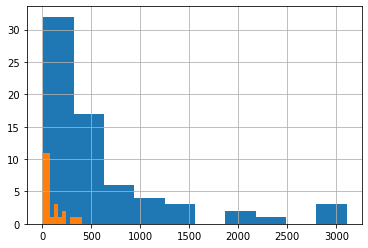

In [4]:
FindmostfittingDistribution("Masse Zone 1",dataFile1["mass"])
FindmostfittingDistribution("Masse Zone 2",dataFile2["mass"])

Die folgenden Verteilungen der Spalte Geschwindigkeit Zone 1 wurden geprüft und fitten am besten in absteigender Reihenfolge:
norm: pvalue=0.05935470523940989
logistic: pvalue=0.05996742225913976
gamma: pvalue=0.06380655082115672
cauchy: pvalue=0.08213316837233586
uniform: pvalue=0.20266106442577037
expon: pvalue=0.3321926521972434
Die folgenden Verteilungen der Spalte Geschwindigkeit Zone 2 wurden geprüft und fitten am besten in absteigender Reihenfolge:
norm: pvalue=0.10464125364475385
gamma: pvalue=0.11342375284786921
logistic: pvalue=0.11663594484492207
cauchy: pvalue=0.14261401090149683
uniform: pvalue=0.22106481481481483
expon: pvalue=0.3161806174860554


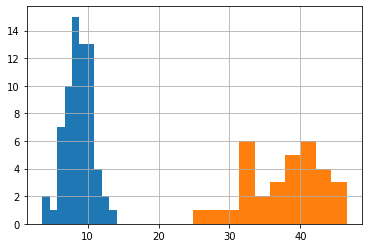

In [5]:
FindmostfittingDistribution("Geschwindigkeit Zone 1",dataFile1["velocity"])
FindmostfittingDistribution("Geschwindigkeit Zone 2",dataFile2["velocity"])

Die folgenden Verteilungen der Spalte Zeit vor Steinen Zone 1 wurden geprüft und fitten am besten in absteigender Reihenfolge:
expon: pvalue=0.0931529745087718
gamma: pvalue=0.09889535159040358
logistic: pvalue=0.15722248146522214
norm: pvalue=0.1617547783807829
cauchy: pvalue=0.20432601098287612
uniform: pvalue=0.5220754716981133
Die folgenden Verteilungen der Spalte Zeit vor Steinen Zone 2 wurden geprüft und fitten am besten in absteigender Reihenfolge:
gamma: pvalue=0.07935560152544935
expon: pvalue=0.12435655842487581
logistic: pvalue=0.1287300431639467
norm: pvalue=0.16489506269504894
cauchy: pvalue=0.17483243919960684
uniform: pvalue=0.39917452830188677


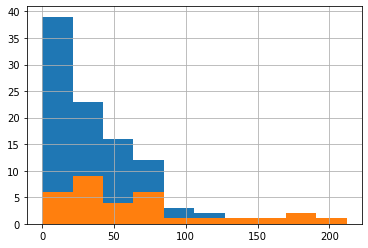

In [6]:
FindmostfittingDistribution("Zeit vor Steinen Zone 1",mergedDataFile["TimebeforeStone"])
FindmostfittingDistribution("Zeit vor Steinen Zone 2",dataFile2["TimebeforeStone"])

### Eigenschaftsübersicht der Beobachtungen
In der Zone 1 wurden 68 Steine beobachtet und in der Zone 2 waren es 32 Beobachtungen.

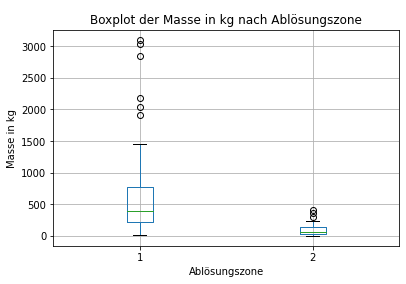

In [7]:
mergedDataFile.boxplot(column = "mass", by = "zone")
plt.title("Boxplot der Masse in kg nach Ablösungszone")
plt.suptitle(" ")
plt.xlabel("Ablösungszone")
plt.ylabel("Masse in kg")
plt.show()


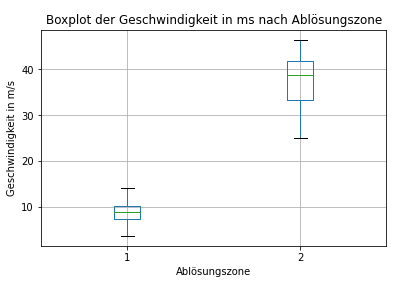

In [8]:
mergedDataFile.boxplot(column = "velocity", by = "zone")
plt.title("Boxplot der Geschwindigkeit in ms nach Ablösungszone")
plt.suptitle(" ")
plt.xlabel("Ablösungszone")
plt.ylabel("Geschwindigkeit in m/s")
plt.show()

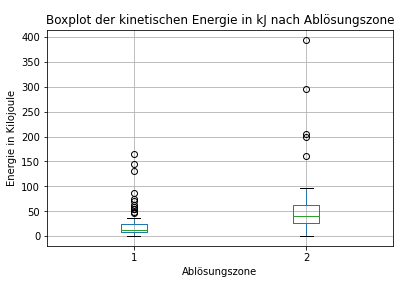

In [9]:
mergedDataFile.boxplot(column = "energy", by = "zone")
plt.title("Boxplot der kinetischen Energie in kJ nach Ablösungszone")
plt.suptitle(" ")
plt.xlabel("Ablösungszone")
plt.ylabel("Energie in Kilojoule") 
plt.show()

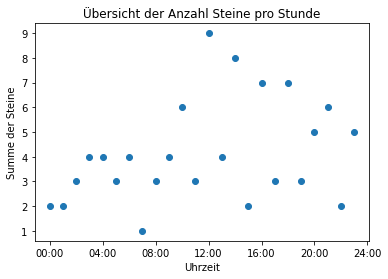

In [10]:
ScatterplotTime = mergedDataFile.groupby(['timestamp']).agg({'Trigger':'sum'})
plt.scatter(ScatterplotTime.index, ScatterplotTime['Trigger'])
plt.xticks(["00:00","04:00","08:00","12:00","16:00","20:00","24:00"])
plt.title("Übersicht der Anzahl Steine pro Stunde")
plt.xlabel("Uhrzeit")
plt.ylabel("Summe der Steine")
plt.show()

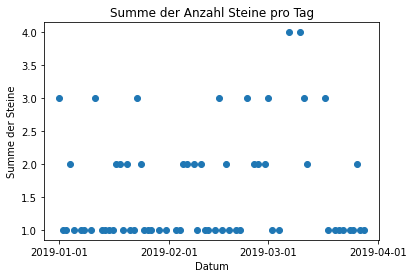

In [11]:
ScatterplotDate = mergedDataFile.groupby(mergedDataFile['DateTime'].dt.date).agg({'Trigger':'sum'})
plt.scatter(ScatterplotDate.index, ScatterplotDate['Trigger'])
plt.xticks(["2019-01-01 00:00:00","2019-02-01 00:00:00","2019-03-01 00:00:00","2019-04-01 00:00:00"])
plt.title("Summe der Anzahl Steine pro Tag")
plt.xlabel("Datum")
plt.ylabel("Summe der Steine")
plt.show()

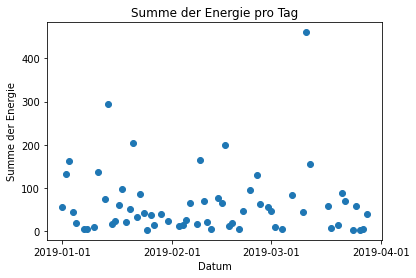

In [12]:
ScatterplotEnergy =mergedDataFile.groupby(mergedDataFile["DateTime"].dt.date).agg({'energy':'sum'}) 
plt.scatter(ScatterplotEnergy.index,ScatterplotEnergy['energy'])
plt.xticks(["2019-01-01 00:00:00","2019-02-01 00:00:00","2019-03-01 00:00:00","2019-04-01 00:00:00"])
plt.title("Summe der Energie pro Tag")
plt.xlabel("Datum")
plt.ylabel("Summe der Energie")
plt.show()

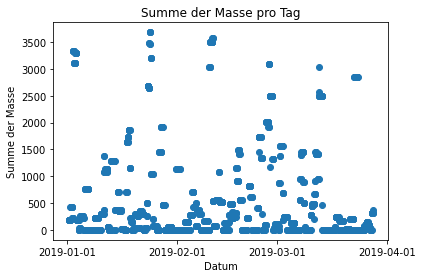

In [13]:
plt.scatter(dfTimeSerie.index,dfTimeSerie['rollingmass24h'])
plt.xticks(["2019-01-01 00:00:00","2019-02-01 00:00:00","2019-03-01 00:00:00","2019-04-01 00:00:00"])
plt.title("Summe der Masse pro Tag")
plt.xlabel("Datum")
plt.ylabel("Summe der Masse")
plt.show()


In [14]:
#Definition der Verteilungsinformationen für die Zonen
listfeatures_distributions_zone1 = [["mass", "exponential"], [
    "velocity", "normal"], ["TimebeforeStone", "exponential"]]
listfeatures_distributions_zone2 = [["mass", "exponential"], [
    "velocity", "normal"], ["TimebeforeStone", "gamma"]]

# Second Mainloop for zone calculations
# Zone 1
listfeatures_samples_zone_1 = pd.DataFrame()
zoneindex = 0

for featureDistribution in listfeatures_distributions_zone1:
    zoneindex = 1
    # calc fit dist features case when dist predefined
    if (featureDistribution[1] == "exponential"):
        explambda = mean(dataFile1[featureDistribution[0]])
        # generate sample
        rng = default_rng()
        sample = rng.exponential(explambda,sizeMonteCarloSim)
        
        listfeatures_samples_zone_1[featureDistribution[0]] = sample
        featureDistribution_zone1 = np.append(featureDistribution, sample)

    elif(featureDistribution[1] == "normal"):
        meanTruncated = mean(dataFile1[featureDistribution[0]])
        stdTruncated = np.std(dataFile1[featureDistribution[0]])
        # generate sample
        rng = default_rng()
        sample = rng.normal(meanTruncated, stdTruncated,
                        size=sizeMonteCarloSim)
        listfeatures_samples_zone_1[featureDistribution[0]] = sample
    elif(featureDistribution[1] == "gamma"):
        meanTruncated = mean(dataFile1[featureDistribution[0]])
        # generate sample
        rng = default_rng()
        sample = rng.gamma(meanTruncated,
                        size=sizeMonteCarloSim)
        listfeatures_samples_zone_1[featureDistribution[0]] = sample

# Zone 2
listfeatures_samples_zone_2 = pd.DataFrame()
zoneindex = 0

for featureDistribution in listfeatures_distributions_zone2:
    zoneindex = 2
    # calc fit dist features case when dist predefined
    if (featureDistribution[1] == "exponential"):
        explambda = mean(dataFile1[featureDistribution[0]])
        # generate sample
        rng = default_rng()
        sample = rng.exponential(explambda, size=sizeMonteCarloSim)
        listfeatures_samples_zone_2[featureDistribution[0]] = sample
        listfeatures_distributions_zone2 = np.append(
            featureDistribution, sample)
    elif(featureDistribution[1] == "normal"):
        meanTruncated = mean(dataFile1[featureDistribution[0]])
        stdTruncated = np.std(dataFile1[featureDistribution[0]])
        # generate sample
        rng = default_rng()
        sample = rng.normal(meanTruncated, stdTruncated,size=sizeMonteCarloSim)
        listfeatures_samples_zone_2[featureDistribution[0]] = sample
    elif(featureDistribution[1] == "gamma"):
        meanTruncated = mean(dataFile2[featureDistribution[0]])
        # generate sample
        rng = default_rng()
        sample = rng.gamma(meanTruncated, size=sizeMonteCarloSim)
        listfeatures_samples_zone_2[featureDistribution[0]] = sample


In [15]:
# Berechnung der Energie der simulierten Steinschläge pro Zone
listfeatures_samples_zone_1['energy'] = (
    (listfeatures_samples_zone_1['mass']/2)*(listfeatures_samples_zone_1['velocity']**2) / 1000)
listfeatures_samples_zone_2['energy'] = (
    (listfeatures_samples_zone_2['mass']/2)*(listfeatures_samples_zone_2['velocity']**2) / 1000)
# # Markierung der Steine, die mit der Energie das Netz durchschlagen haben
listfeatures_samples_zone_1['direct_breakthrough'] = np.where(
    (listfeatures_samples_zone_1["energy"] >= 1000), 1, 0)
listfeatures_samples_zone_2['direct_breakthrough'] = np.where(
    (listfeatures_samples_zone_2["energy"] >= 1000), 1, 0)

listfeatures_samples_zone_1['Zone'] = 1
listfeatures_samples_zone_2['Zone'] = 2


# Berechnung Masse im Netz

listfeatures_samples_zone_1["CumsumHoursbeforeStone"] = listfeatures_samples_zone_1["TimebeforeStone"].cumsum()
listfeatures_samples_zone_2["CumsumHoursbeforeStone"] = listfeatures_samples_zone_2["TimebeforeStone"].cumsum()


listfeatures_samples = listfeatures_samples_zone_1.append(listfeatures_samples_zone_2, ignore_index=True)


listfeatures_samples = listfeatures_samples.sort_values(by='CumsumHoursbeforeStone')
listfeatures_samples = listfeatures_samples.reset_index(drop=True)

listfeatures_samples["Year"] = listfeatures_samples['CumsumHoursbeforeStone'].floordiv(8760)


# Berechnet, wieviel Masse pro Tag im Netz ist, aber nicht, ob es wegen dem letzten gerissen ist...
listfeatures_samples["Tag"] = listfeatures_samples['CumsumHoursbeforeStone'] // 24
Netzvoll = listfeatures_samples.groupby("Tag")["mass"].agg("sum")
Netzvoll = pd.DataFrame({'Tag': Netzvoll.index, 'Tagesmasse': Netzvoll.values})
listfeatures_samples = listfeatures_samples.merge(Netzvoll, how="left", on="Tag")
listfeatures_samples["PossibleBreachFullNet"] = np.where((listfeatures_samples["energy"] >= 500) & (listfeatures_samples["Tagesmasse"] >= 2000), 1, 0)


CountBreachFullNet = 0
ListPossibleBrechFullNet = listfeatures_samples[listfeatures_samples["PossibleBreachFullNet"] == 1]
ListPossibleBrechFullNet = ListPossibleBrechFullNet.reset_index()
for i in range(len(ListPossibleBrechFullNet)):
    Day = ListPossibleBrechFullNet.loc[i, "Tag"]
    ToCheck = listfeatures_samples[listfeatures_samples["Tag"] == Day]
    ToCheck = ToCheck.reset_index()
    ToCheck["CumsumMass"] = ToCheck["mass"].shift().cumsum()
    for i in range(len(ToCheck)):
        if ToCheck.loc[i, "direct_breakthrough"] == 1:
            break  # break weil wenn das Netz durchbrochen ist, die Strasse gesperrt wird
        else:
            if (ToCheck.loc[i, "energy"] >= 500) & (ToCheck.loc[i, "CumsumMass"] >= 2000):
                CountBreachFullNet += 1
                break

print("Anzahl simulierter Jahre:", listfeatures_samples["Year"].max())
print("Anzahl Durchbrüche nach vollem Netz:", CountBreachFullNet)
print("Anzahl direkter Durchbrüche:",listfeatures_samples["direct_breakthrough"].sum())


Anzahl simulierter Jahre: 27495.0
Anzahl Durchbrüche nach vollem Netz: 6
Anzahl direkter Durchbrüche: 1


In [16]:
#Breaches / Jahre * Auto Probabilty * Todefall Probability


AllBreaches = float(CountBreachFullNet + listfeatures_samples["direct_breakthrough"].sum())
MaxYears = float(listfeatures_samples["Year"].max())
#Angenommener Wert
ProbabilityAuto = float(0.1)
ProbabilityDeath = float(4/14)


DangerProbability = AllBreaches / MaxYears  * ProbabilityAuto * ProbabilityDeath

print(DangerProbability)
print(LimitProbability)

if AllBreaches == 0:
    print("Keine Durchbrüche vorhanden. Die Simulationanzahl muss erhöht werden.")

if DangerProbability >= LimitProbability :
    print("Wahrscheinlichkeitsgrenzwert überschritten.")
    
else:
    print("Wahrscheinlichkeitsgrenzwert nicht überschritten. Strasse kann offen bleiben!")
        


#Auto Probability
#60 km/h -> ms
# Gefahrenzone pro AUto 40m (4m auto + 36 m bremsweg)
# Steingrösse 1m
# Wie lange ist ein Auto in der Gefahrenzone (40m) 

7.274049827241317e-06
0.0001
Wahrscheinlichkeitsgrenzwert nicht überschritten. Strasse kann offen bleiben!
